# RSJ model: CPR of $I(\phi)=[\sin(\phi)+\eta\sin(2\phi)]+A(\sin(\phi+C)+\eta\sin[2(\phi+C)])$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import rc

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False


from scipy.integrate import odeint
from scipy.optimize import fmin
from scipy.io import savemat

In [2]:
%matplotlib inline

In [3]:
%load_ext Cython

In [12]:
h=6.626e-34
hbar=h/2/np.pi
Qe=1.608e-19

In [21]:
%%cython
cimport numpy as np
from libc.math cimport sin, cos, atanh,pi
import numpy as np

h=6.626e-34
hbar=h/2/pi
Qe=1.608e-19
Ic=2e-6
Rn=13
cpdef double CPR(double G, double A, double eta, double C):
    '''
        Current-phase relationship for the junction
    '''
    return sin(G)+eta*sin(2*G)+A*sin(G+C)+A*eta*sin(2*G+2*C)
    
cpdef double dGdt(G,double t,double I,double A, double eta,double C):
    '''
        Define y = [gamma]
        dy_dt =  - f(gamma) + i(t)) 
    '''
    der = 2*Qe*Rn*(I-Ic*CPR(G,A,eta,C))/hbar
    return der 


### Plot CPR

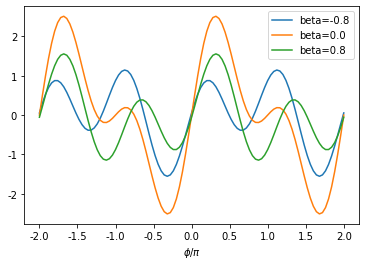

In [14]:
eta=0.7
A=0.7
def CPR2(G, A, eta, C):
    return np.sin(G)+eta*np.sin(2*G)+A*np.sin(G+C)+A*eta*np.sin(2*G+2*C)
phi=np.linspace(-2,2,101)*np.pi

beta=np.pi*np.linspace(-0.8,0.8,3)

Is=np.empty([len(phi),len(beta)])
plt.figure()
for j in range(0,len(beta)):
    for i in range(0,len(phi)):
        Is[i,j]=CPR2(phi[i],A,eta,beta[j])
    plt.plot(phi/np.pi,Is[:,j],label="beta="+str(np.round(beta[j]/np.pi,3)))
plt.xlabel('$\phi/\pi$')
plt.legend(loc=1)


In [15]:
from IPython import display

In [19]:
f0=2*Qe*Ic*Rn/h

C=np.pi*np.arange(-1,1.05,0.05)
eta_array=np.linspace(0,1,11)
A_array=np.linspace(0,1,11)
IDC_step=0.005
IDC_Sweep=np.array([-4,4,IDC_step])*Ic
IDC_array=np.arange(IDC_Sweep[0],IDC_Sweep[1],IDC_Sweep[2])
V=np.empty([len(C),len(IDC_array)])
DVDI=np.empty([len(C),len(IDC_array)])

print(IDC_array.shape)
print(C.shape)

(1600,)
(41,)


## Model,  Dynamic Plot & Save .mat

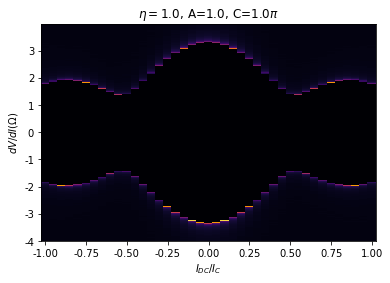

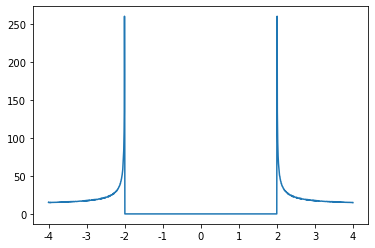

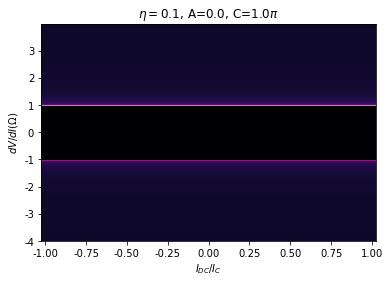

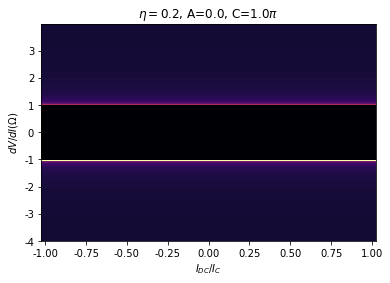

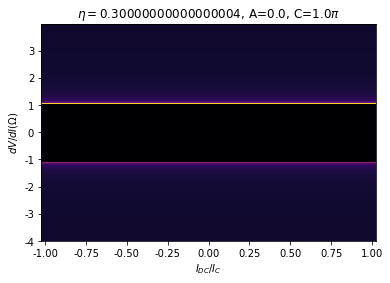

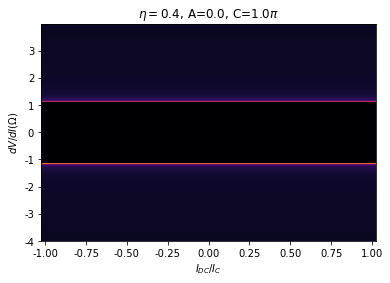

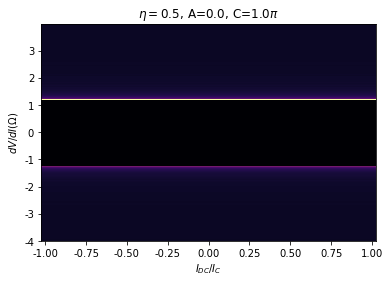

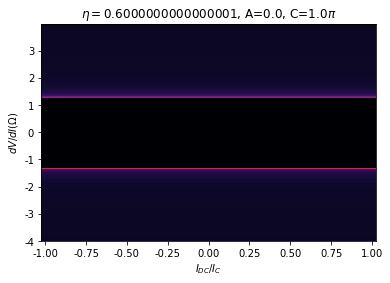

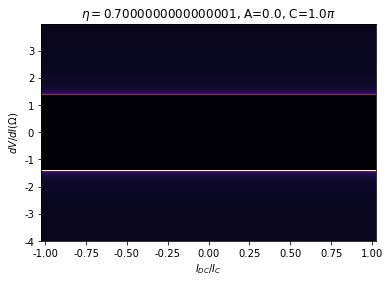

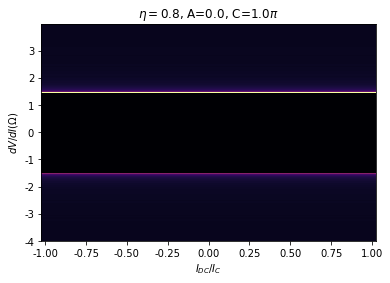

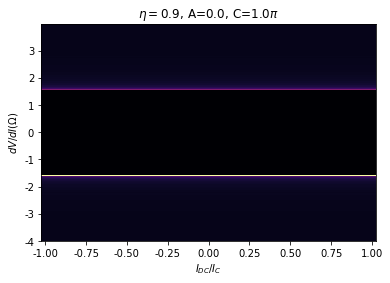

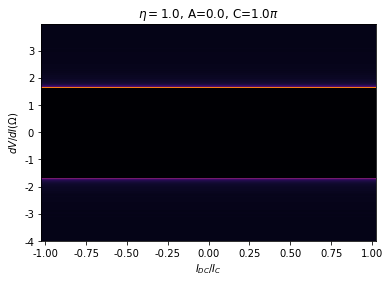

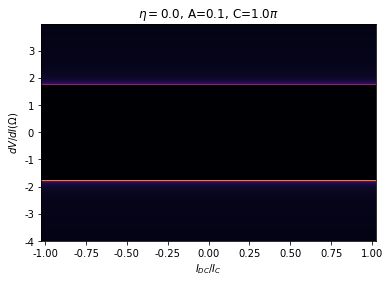

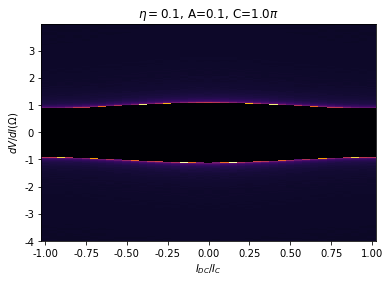

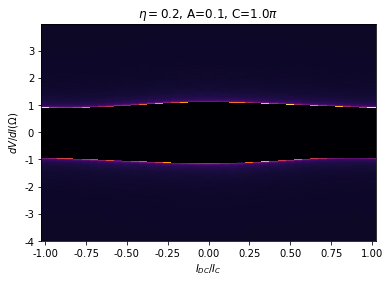

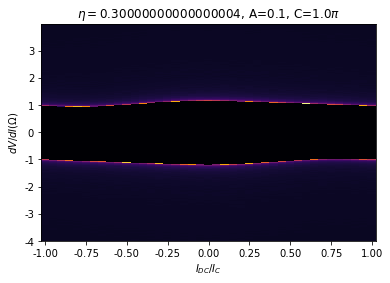

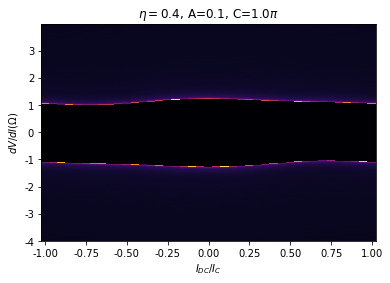

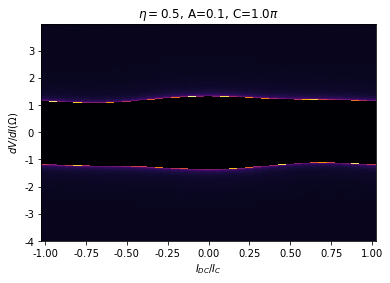

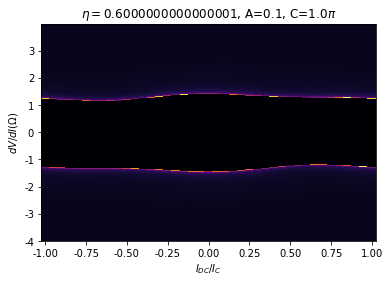

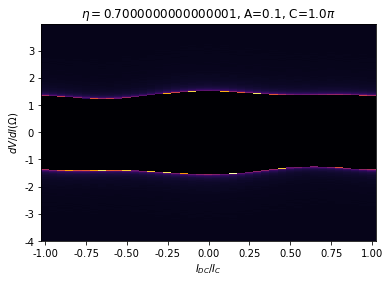

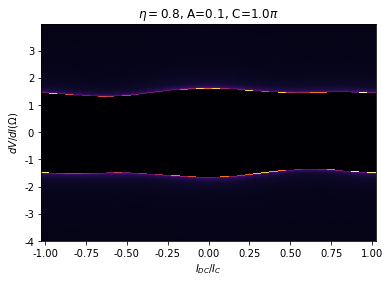

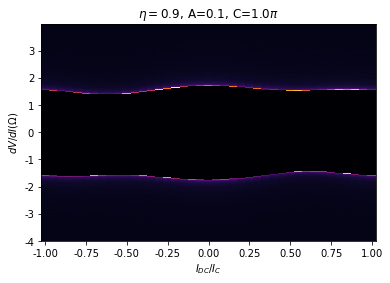

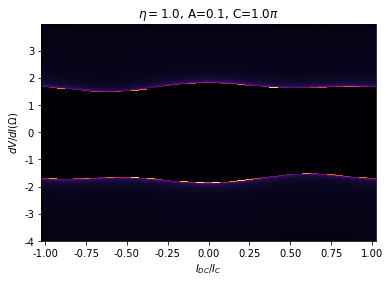

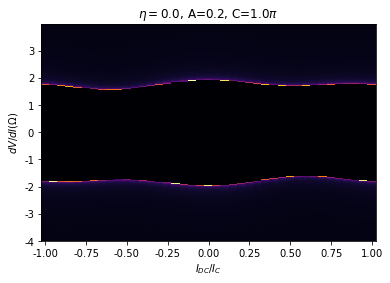

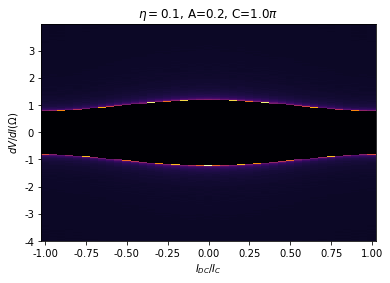

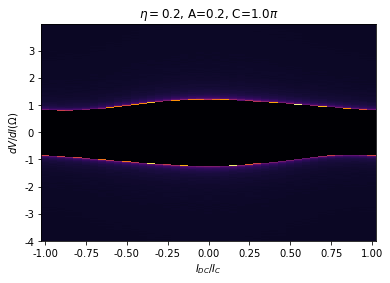

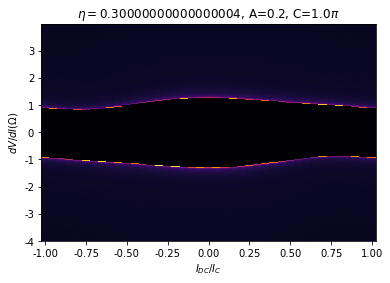

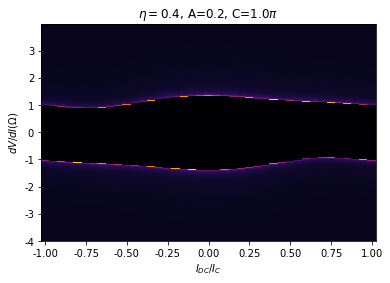

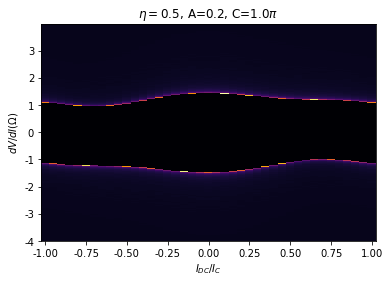

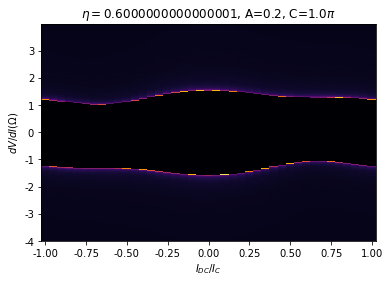

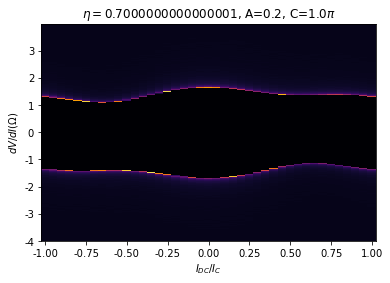

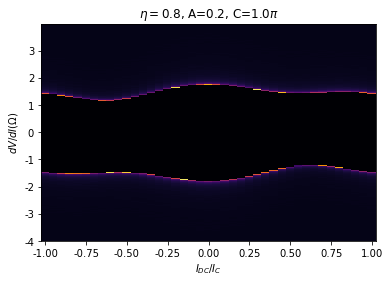

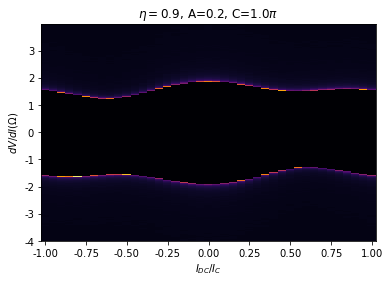

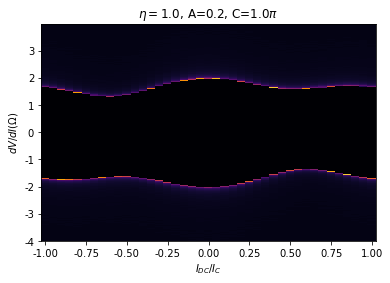

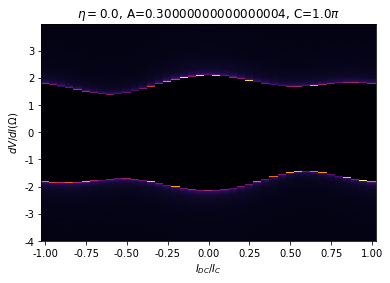

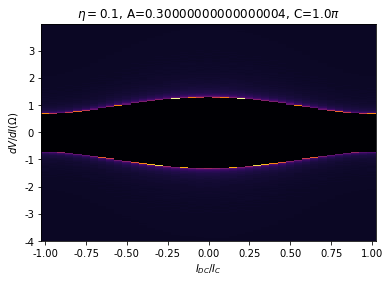

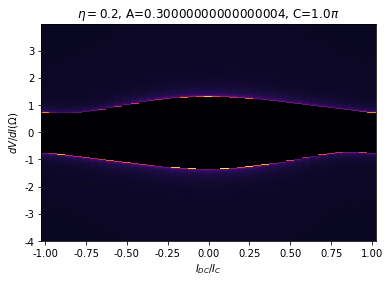

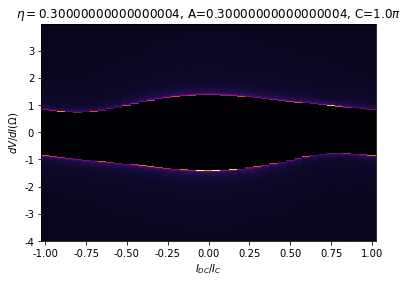

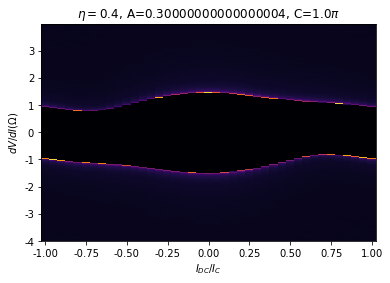

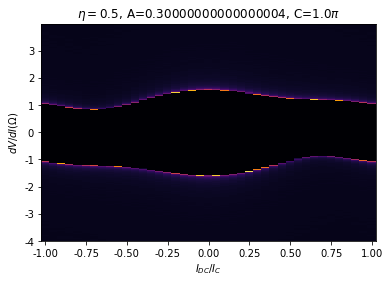

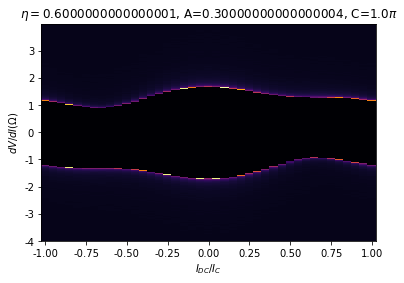

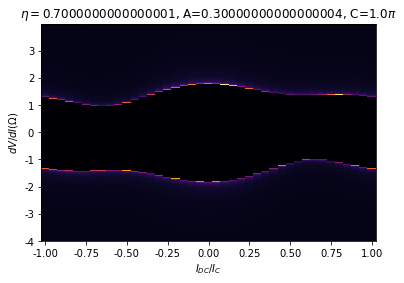

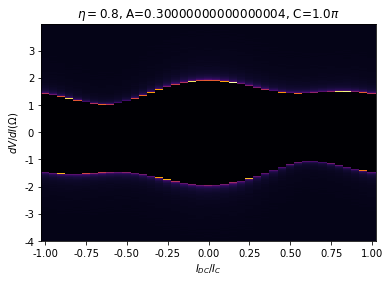

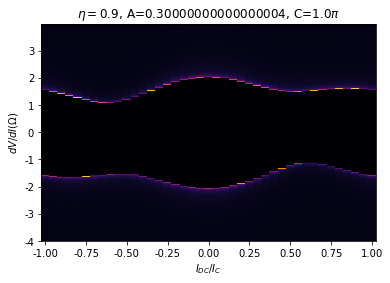

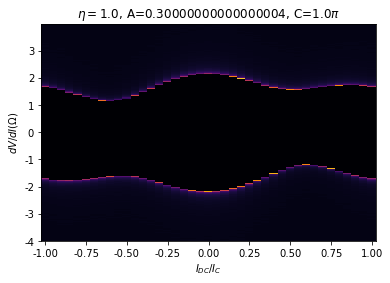

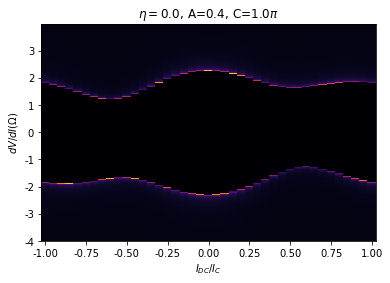

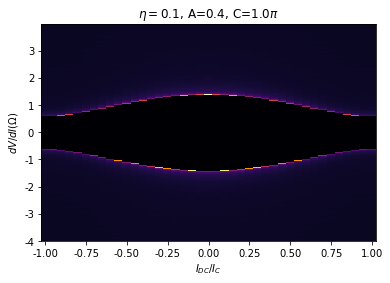

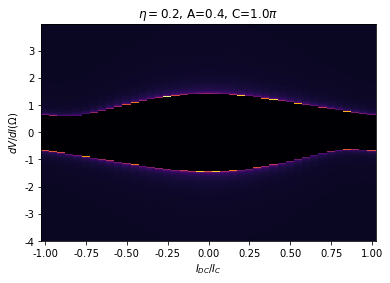

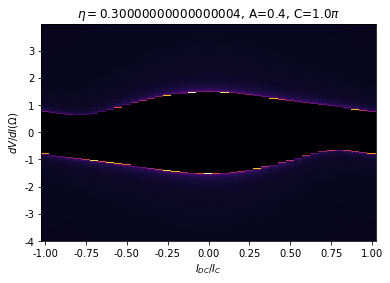

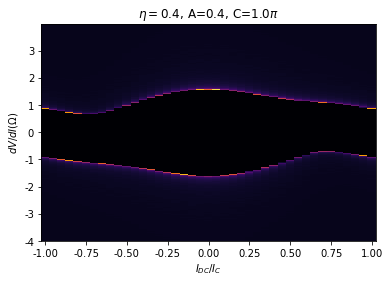

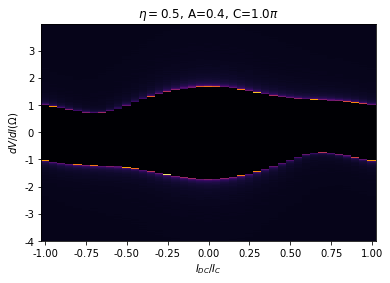

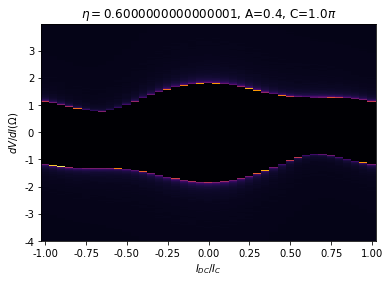

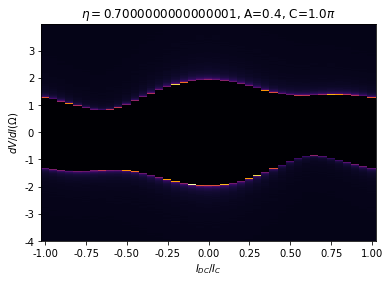

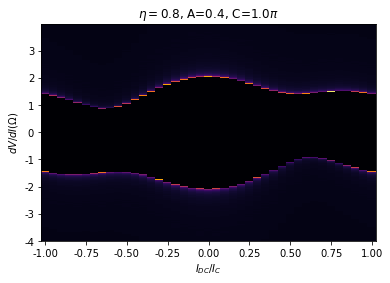

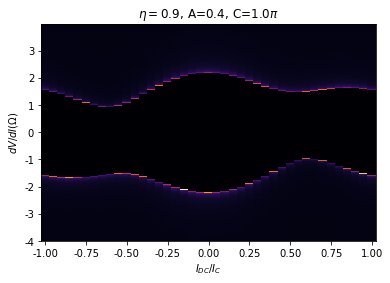

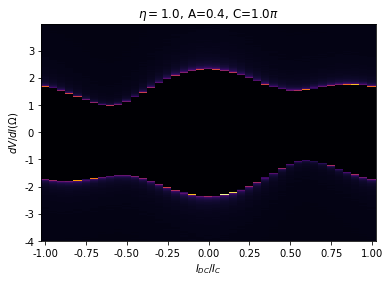

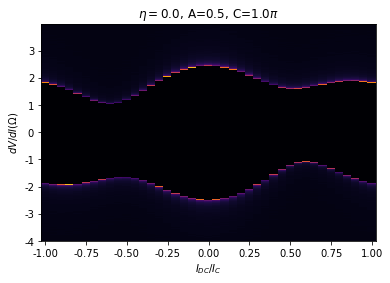

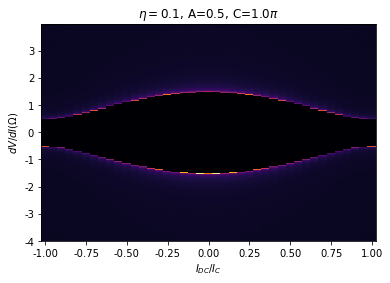

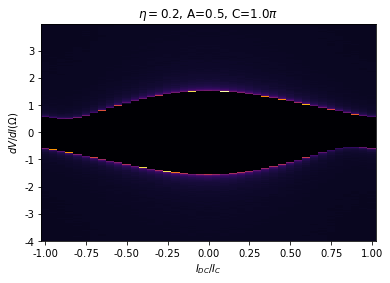

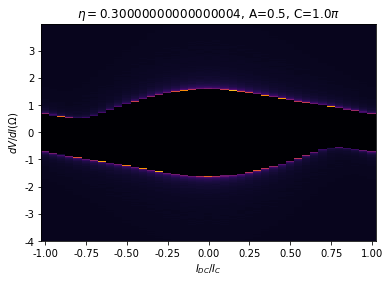

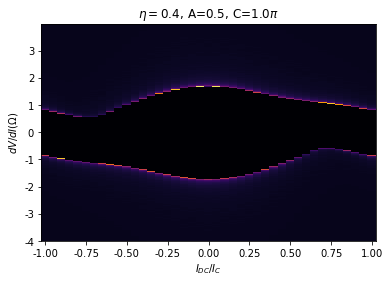

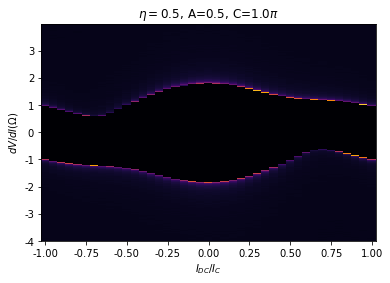

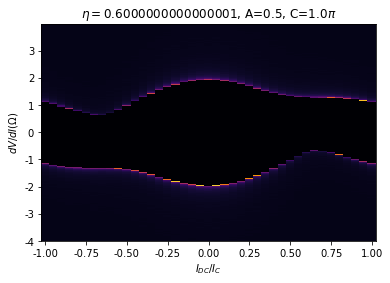

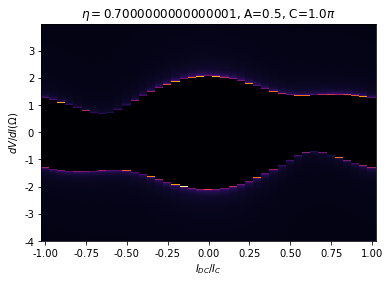

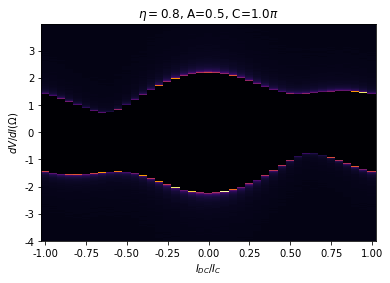

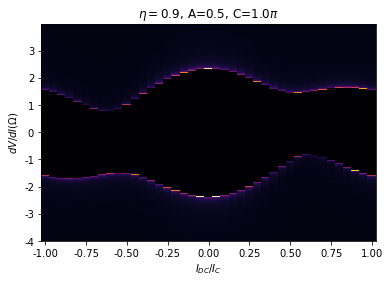

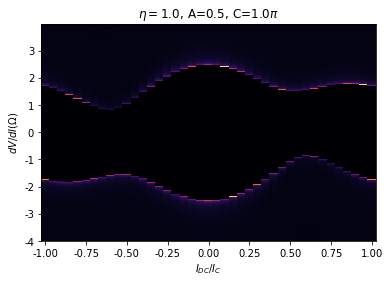

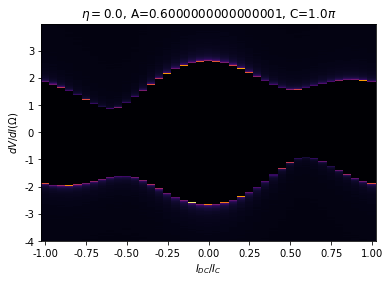

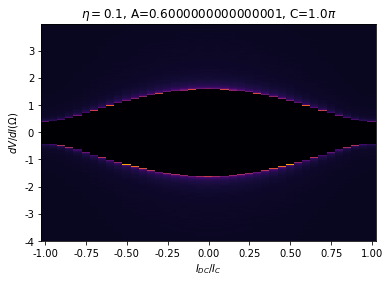

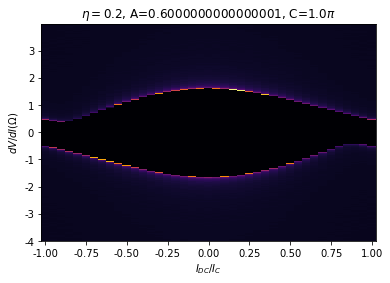

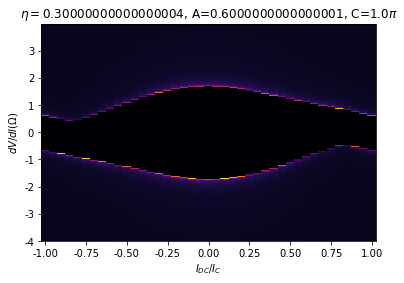

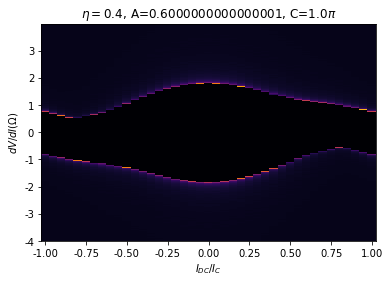

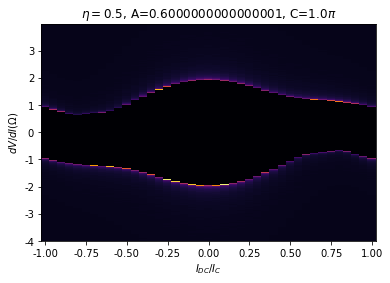

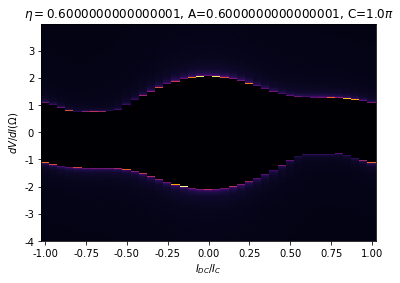

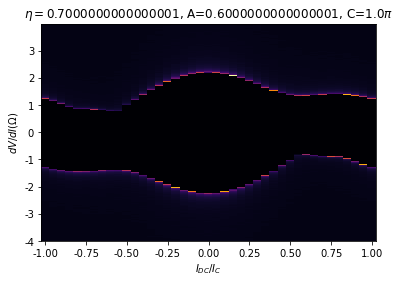

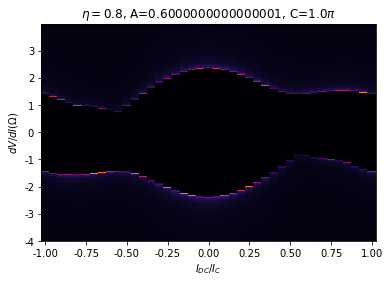

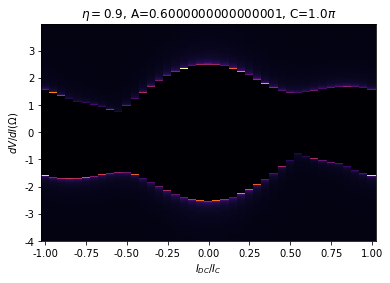

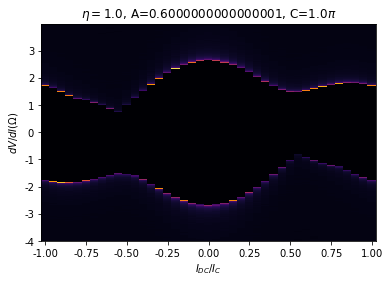

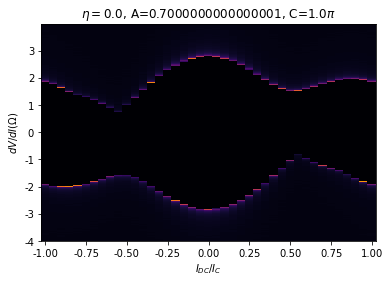

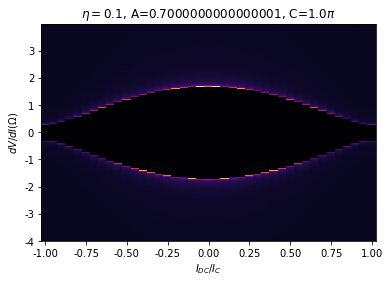

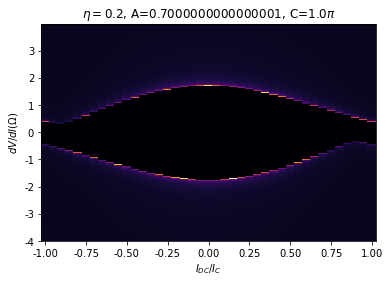

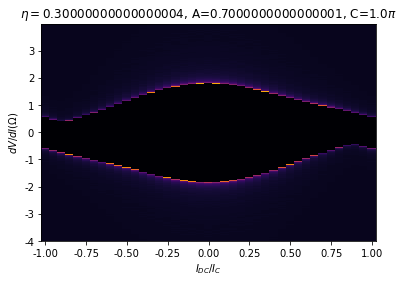

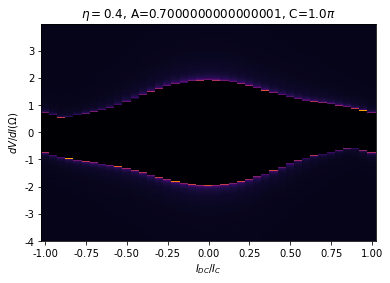

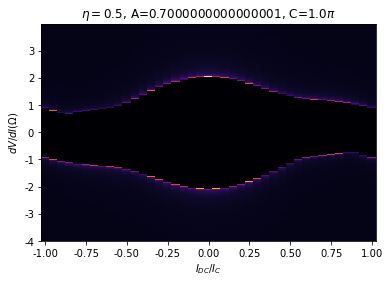

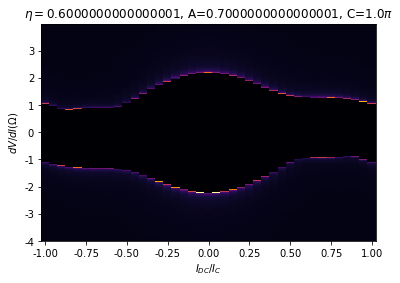

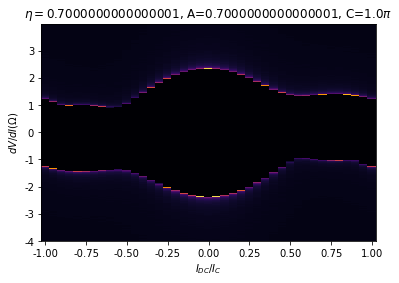

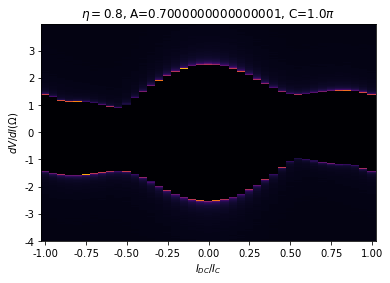

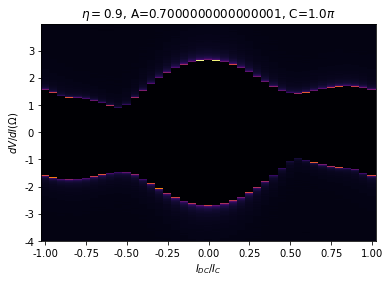

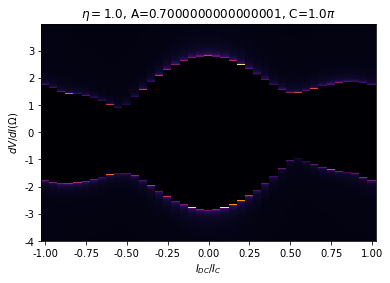

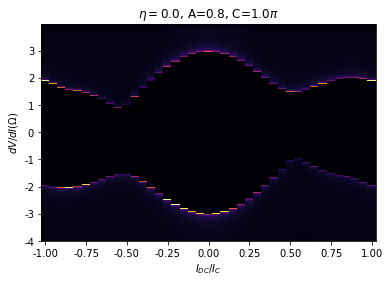

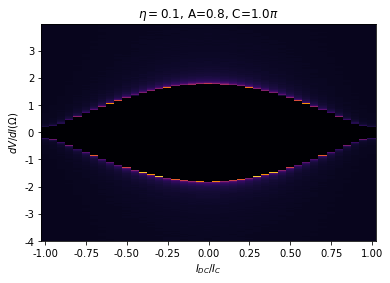

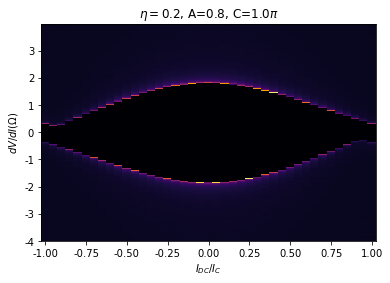

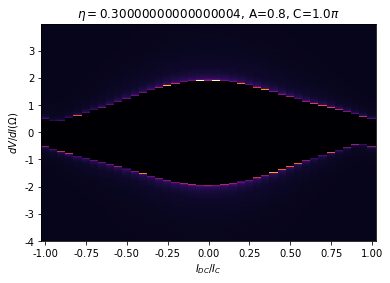

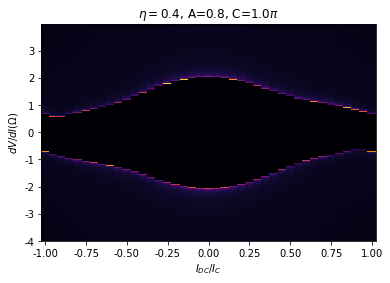

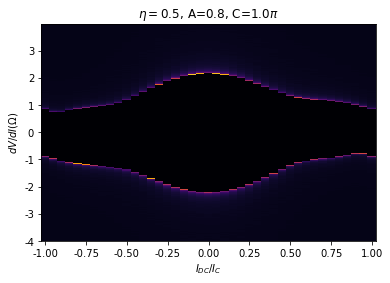

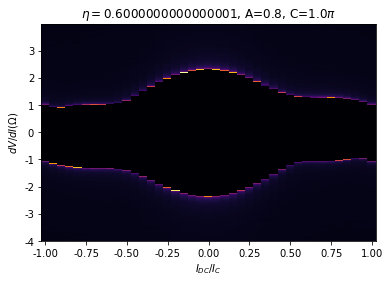

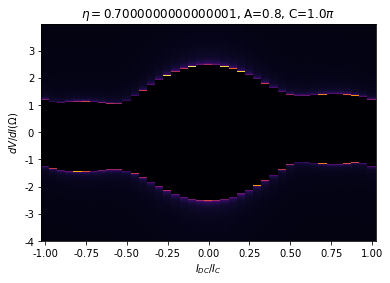

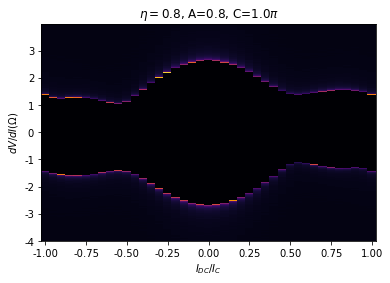

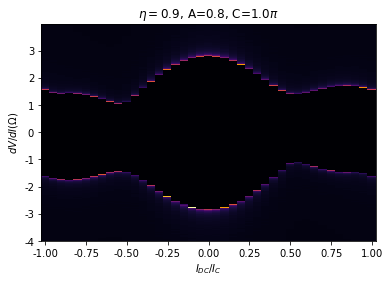

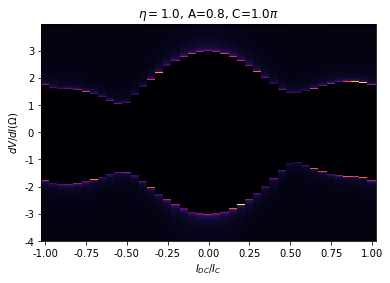

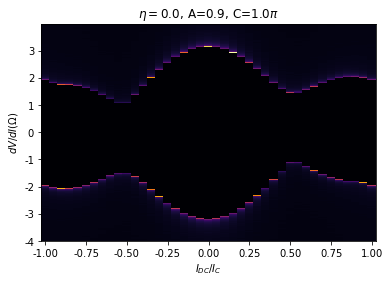

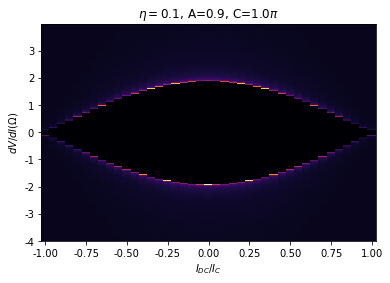

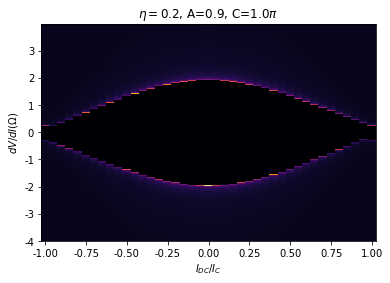

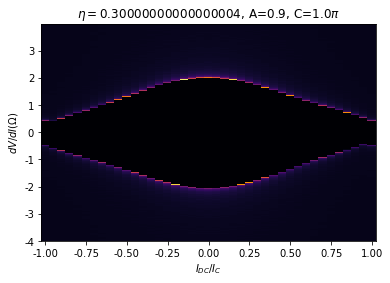

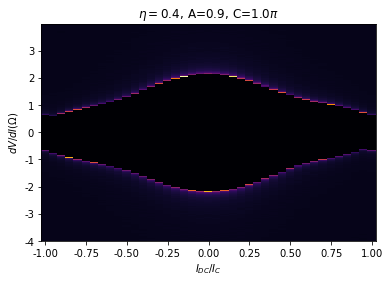

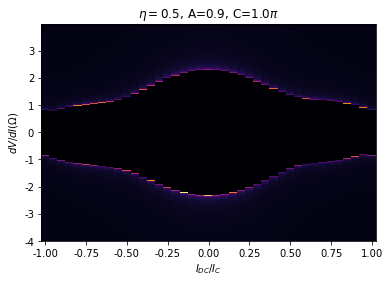

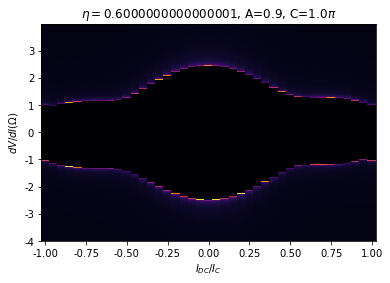

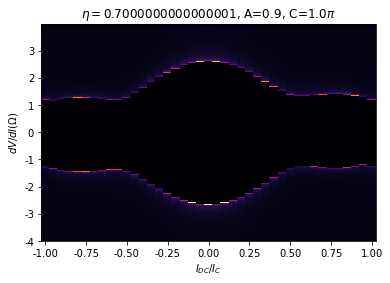

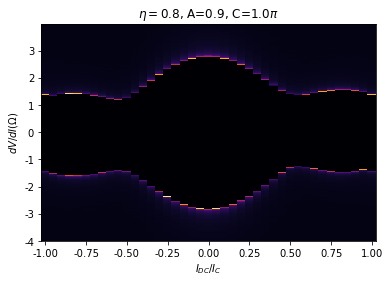

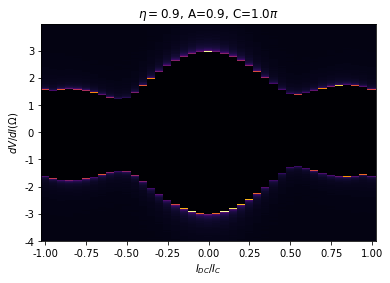

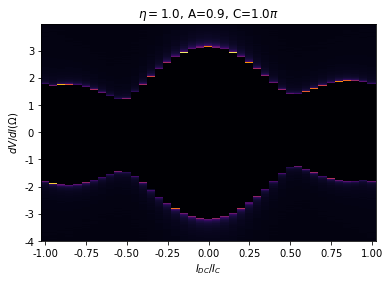

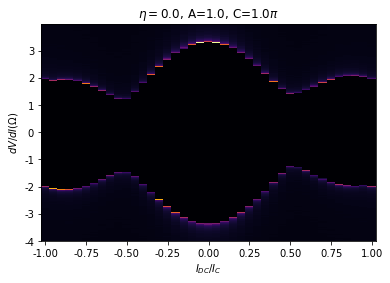

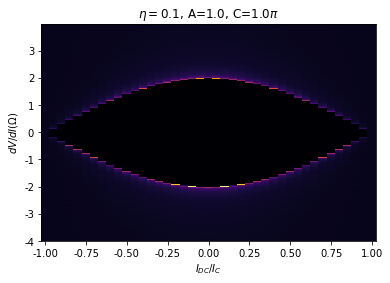

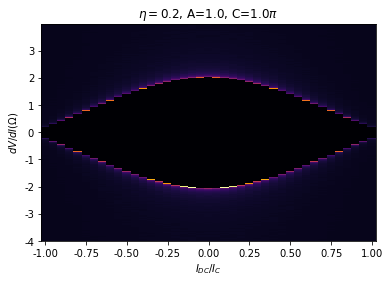

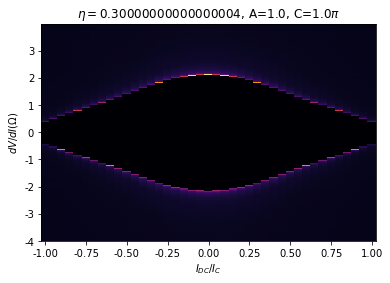

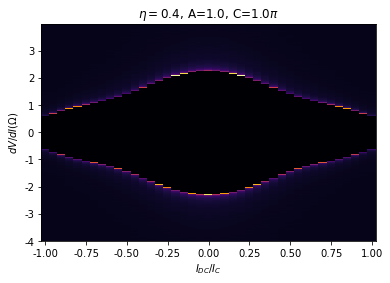

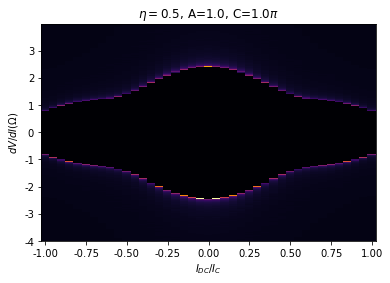

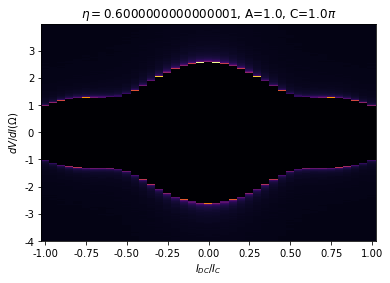

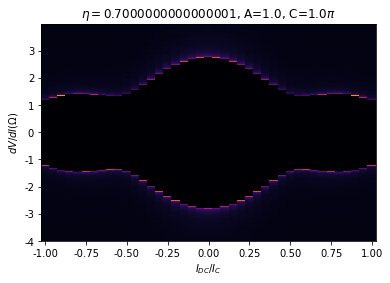

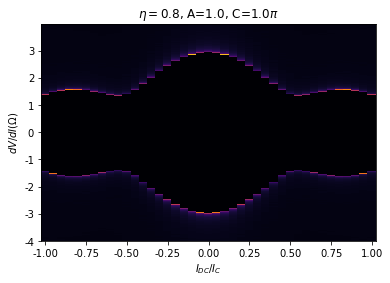

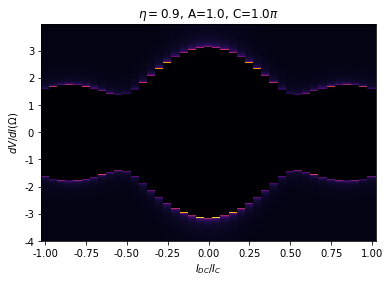

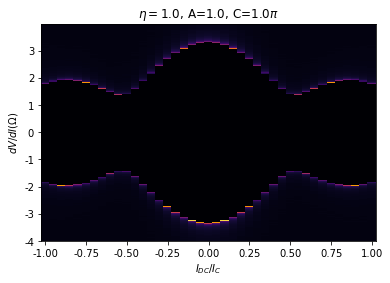

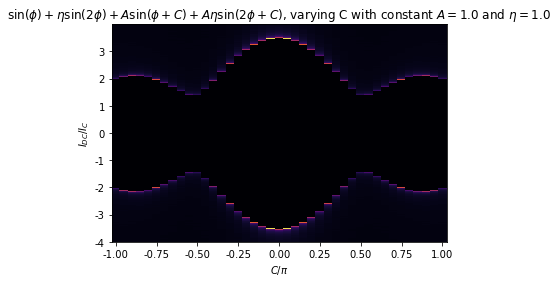

In [20]:
plt.ion()
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

for A in A_array:
    for eta in eta_array:
        for x in range(0,len(C)):
            display.clear_output(wait=True)

            for j in range(0,len(IDC_array)):
                t=np.arange(0,500.01,0.01)/f0
                G_array= odeint(dGdt,0,t,args=(IDC_array[j],A,eta,C[x]))
                #V[x,j]=np.squeeze(G_array[-1]-G_array[-1501])*f0*(hbar/2/Qe)/15 # Doesn't work for some cases.
                V[x,j]=np.mean(np.gradient(G_array[:-3001,0]))/(0.01/f0)*(hbar/2/Qe)
            DVDI[x,:]=np.gradient(V[x,:],IDC_step*Ic)
            #print("C="+str(C[x]/np.pi)+"$\pi$",end="\r")
            ax.clear()
            ax.plot(IDC_array/Ic,DVDI[x,:])
            plt.title("$\eta=$"+str(eta)+", A="+str(A)+", C="+str(np.round(C[x]/np.pi,3))+"$\pi$")
            plt.xlabel("$I_{DC}/I_C$")
            plt.ylabel("$dV/dI(\Omega)$")
            display.display(plt.gcf())

        plt.figure()
        plt.pcolor(C/np.pi,IDC_array/Ic,np.transpose(DVDI),cmap='inferno',shading='auto')
        plt.xlabel("$C/\pi$")
        plt.ylabel("$I_{DC}/I_C$")
        plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
#plt.savefig("./several_eta_A/two_channels_A"+str(A)+"_eta_"+str(eta)+"_step_0p005_41ptC.pdf")

        savemat("./several_eta_A/two_channels_A"+str(A)+"_eta_"+str(eta)+"_step_0p005_41ptC.mat",mdict={'IDC':IDC_array,'C':C,'V':V,'DVDI':DVDI,'eta':eta,'A':A})


### Plot map and save data

In [ ]:
plt.figure()
plt.pcolor(C/np.pi,IDC_array/Ic,np.transpose(DVDI),cmap='inferno',shading='auto')
plt.xlabel("$C/\pi$")
plt.ylabel("$I_{DC}/I_C$")
plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
plt.savefig("./eta0p7_A0p5/two_channels_A0p5_eta_0p7_step_0p005_41ptC.pdf")

savemat("./eta0p7_A0p5/simulation_dVdI_vs_C_constant_A_0p5_eta_0p7_two_channels_step_0p005.mat",mdict={'IDC':IDC_array,'C':C,'V':V,'DVDI':DVDI})


### load data and plot

In [ ]:
from scipy.io import loadmat

In [ ]:
data=loadmat("./eta0p7_A0p5/simulation_dVdI_vs_C_constant_A_0p5_eta_0p7_two_channels_step_0p005.mat")
IDC=np.squeeze(data['IDC'])
C=np.squeeze(data['C'])
V=data['V']
DVDI=data['DVDI']
Ic=2e-6
Rn=13


plt.figure()
ax=plt.pcolor(C/np.pi,IDC/Ic,np.transpose(DVDI),cmap='inferno',linewidth=0,rasterized=True,shading='auto')
plt.xlabel("$\delta/\pi$")
plt.ylabel("$I_{DC}/I_C$")
plt.colorbar()

plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
#plt.savefig("delta_in_sin2phi.pdf")


# Save it into a .csv file

In [ ]:
np.savetxt("./eta0p7_A0p7/csv/IDC.csv", IDC, delimiter=",")
np.savetxt("./eta0p7_A0p7/csv/C.csv", C, delimiter=",")
np.savetxt("./eta0p7_A0p7/csv/V.csv", V, delimiter=",")
np.savetxt("./eta0p7_A0p7/csv/DVDI.csv", DVDI, delimiter=",")


In [ ]:
print(C.shape)
print(IDC_array.shape)

In [ ]:
from scipy.signal import find_peaks
#i=20 #58 for (0.16pi,0.83), 92 for (0.84pi,0.83)
Icn=np.empty(len(C))
Icp=np.empty(len(C))
peak_n=np.empty(len(C))
peak_p=np.empty(len(C))
asymmetry=np.empty(len(C))
for i in range(0,len(C)):
    Index, Height=find_peaks(DVDI[i,:],distance=200,height=50)
    
    Icn[i]=np.abs(IDC_array[Index[0]])
    Icp[i]=np.abs(IDC_array[Index[1]])
    asymmetry[i]=Icp[i]/Icn[i]
    peak_n[i]=Height['peak_heights'][0]
    peak_p[i]=Height['peak_heights'][1]
    if(len(Index)>2):
        print("C= "+str(np.round(C[i]/np.pi,3))+"*pi has more than one peak: "+str(C[i])+" at "+str(Index))

In [ ]:
plt.figure()
plt.plot(C/np.pi,peak_p,'.-',label='Peak height at $I_{C+}$')
#plt.plot(C/np.pi,np.flip(peak_n),'.',label='Peak height at $I_{C-}$, flipped, same as blue')
plt.plot(C/np.pi,peak_n,'.-',label='Peak height at $I_{C-}$')
plt.xlabel('$C/\pi$')
plt.ylabel('$dV/dI(\Omega)$')
plt.legend(loc=0)

plt.figure()
plt.plot(C/np.pi,peak_n/peak_p,'.-',label='Peak height ratio $I_{C-}/I_{C+}$')
plt.xlabel('$C/\pi$')
plt.ylabel('Peak height ratio $I_{C-}/I_{C+}$')


In [ ]:
plt.figure()
plt.plot(C/np.pi,asymmetry,'.-', label='asymmetry =$I_{C+}/I_{C-}$')
plt.legend(loc=2)
plt.xlabel('$C/\pi$')
plt.ylabel('asymmetry =$I_{C+}/I_{C-}$')

In [ ]:
plt.figure()
plt.plot(C/np.pi,Icp/Ic,label='$I_{C+}$')
plt.plot(C/np.pi,Icn/Ic,label='$I_{C-}$')
plt.xlabel('$C/\pi$')
plt.ylabel('$I_C(C)/I_C$')
plt.legend(loc=1)

In [ ]:
plt.figure()
plt.plot(IDC_array/Ic,DVDI[4,:],'.-',label='$C=$'+str(np.round(C[4]/np.pi,3))+"$\pi$")
plt.xlim([-1.8,-1.5])
plt.xlabel('$I_{DC}/I_C$')
plt.ylabel('$dV/dI(\Omega$')
plt.legend(loc=1)

In [ ]:
plt.figure()
plt.plot(IDC_array/Ic,DVDI[2,:],'.-',label='$C=$'+str(np.round(C[2]/np.pi,4))+"$\pi$")
plt.xlim([-1.35,-1.5])
plt.xlabel('$I_{DC}/I_C$')
plt.ylabel('$dV/dI(\Omega$')
plt.legend(loc=1)

In [ ]:
plt.figure()
plt.plot(IDC_array/Ic,DVDI[4,:],'-',label='$C=$'+str(np.round(np.transpose(C[4])/np.pi,3))+"$\pi$")
#plt.xlim([-2,-1.5])
plt.xlabel('$I_{DC}/I_C$')
plt.ylabel('$dV/dI(\Omega$')
plt.legend(loc=1)

In [ ]:
plt.figure()
#alist=[0,2,8,10,12,18,20]
alist=[0,4,16,20,24,36,40]

for i in alist :
    plt.plot(IDC_array/Ic,V[i,:]/Ic/Rn,'-',label='$C=$'+str(np.round(C[i]/np.pi,3))+"$\pi$")
#plt.xlim([-4,3])
#plt.ylim([-0.00005,0.000025])
plt.xlabel('$I_{DC}/I_C$')
plt.ylabel('$V/I_CR_N$')
plt.legend(loc=0)